# Component Selection and Data Pipeline Implementation code

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql.functions import substring, length, expr
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
import pyspark.sql.functions as sq
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkFiles
from pyspark.ml.stat import Correlation
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, desc, col, to_date
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns; sns.set_theme()
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorIndexer
import warnings
import itertools

In [2]:
from pyspark.context import SparkContext

In [3]:
from pyspark.sql import SQLContext

In [4]:
spark = SparkSession\
.builder\
.appName("Spark Crime Analysis")\
.config("spark.some.config.option", "some-value")\
.getOrCreate()

In [5]:
#Check we have a spark context: Should show the spark version and app name
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Spark Crime Analysis>

In [6]:
#Importing all crime and LSOA data from Blob storage 
!wget https://odogwublob.blob.core.windows.net/newcontainer/all_crimes21_hdr.txt.gz
!wget https://odogwublob.blob.core.windows.net/newcontainer/LSOA_pop_v2.csv

--2022-12-22 21:27:13--  https://odogwublob.blob.core.windows.net/newcontainer/all_crimes21_hdr.txt.gz
Resolving odogwublob.blob.core.windows.net (odogwublob.blob.core.windows.net)... 52.239.169.132
Connecting to odogwublob.blob.core.windows.net (odogwublob.blob.core.windows.net)|52.239.169.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2491979339 (2.3G) [application/x-gzip]
Saving to: ‘all_crimes21_hdr.txt.gz’

all_crimes21_hdr.tx 100%[===================>]   2.32G   119MB/s    in 23s     

2022-12-22 21:27:37 (102 MB/s) - ‘all_crimes21_hdr.txt.gz’ saved [2491979339/2491979339]

--2022-12-22 21:27:43--  https://odogwublob.blob.core.windows.net/newcontainer/LSOA_pop_v2.csv
Resolving odogwublob.blob.core.windows.net (odogwublob.blob.core.windows.net)... 52.239.169.132
Connecting to odogwublob.blob.core.windows.net (odogwublob.blob.core.windows.net)|52.239.169.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2505684 (2.4M) [text

In [7]:
# Defining the schema for all crime data
crime_schema = StructType(
    [StructField('Crime ID',StringType(),True),
     StructField('Month',DateType(),True),
     StructField('Reported by',StringType(),True),
     StructField('Falls within',StringType(),True),
     StructField('Longitude',DoubleType(),True),
     StructField('Latitude',DoubleType(),True),
     StructField('Location',StringType(),True),
     StructField('LSOA code',StringType(),True),
     StructField('LSOA name',StringType(),True),
     StructField('Crime type',StringType(),True),
     StructField('Last outcome category',StringType(),True)
    ])

In [8]:
# Defining the schema for all LSOA data
LSOA_DATA =StructType(
    [StructField('date',IntegerType(),True),
     StructField('geography',StringType(),True),
     StructField('geography code',StringType(), True),
     StructField('Rural Urban',StringType(), True),
     StructField('Variable: All usual residents; measures: Value',IntegerType(), True),
     StructField('Variable: Males; measures: Value',IntegerType(),True),
     StructField('Variable: Females; measures: Value',IntegerType(), True),
     StructField('Variable: Lives in a household; measures: Value',IntegerType(), True),
     StructField('Variable: Lives in a communal establishment; measures: Value',IntegerType(), True),
     StructField('Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value',IntegerType(), True),
     StructField('Variable Area (Hectares); measures: Value',DoubleType(), True),
     StructField('Variable Density (number of persons per hectare); measures: Value',DoubleType(),True)
    ])

In [9]:
crime_import = spark.read.csv("all_crimes21_hdr.txt.gz", header=True, schema=crime_schema)
crime_import2 = crime_import.withColumnRenamed("Crime type","CrimeType") \
.withColumnRenamed("Last outcome category","Last_outcome") \
.withColumnRenamed("Month","Crime_Date")\
.withColumnRenamed("LSOA name","LSOA_name")

In [10]:
LSOA_df = spark.read.csv("LSOA_pop_v2.csv", header=True, schema= LSOA_DATA)
LSOA_df2 = LSOA_df.select('geography', 'Variable: All usual residents; measures: Value')
LSOA_df2 = LSOA_df2.withColumnRenamed("Variable: All usual residents; measures: Value","Population")
LSOA_df2 = LSOA_df2.withColumnRenamed('geography','City_code')

# Data Extraction and Filtering 

1.	Filter the dataset so that crimes refer to appropriate crimes only
2.  To see whether crime cartegories are increasing, i will also need to extract them as a time series.
3.  I will be using diagnostic checks throughout this report.

In [11]:
crime_import2.count()

65078250

In [12]:
LSOA_df2.agg({'Population': 'sum'}).show()
LSOA_df2.count()

+---------------+
|sum(Population)|
+---------------+
|       56075912|
+---------------+



34753

## Are Violent crimes are increasing?

In [13]:
#selecting releveant columns from the Dataset to avoid ambiguity and Irrelevant data sets or columns.

crime_df1 = crime_import2.select('Crime_Date', 'CrimeType')

crime_df1.show(10)
crime_df1.count()

+----------+--------------------+
|Crime_Date|           CrimeType|
+----------+--------------------+
|2010-12-01|         Other crime|
|2010-12-01|Anti-social behav...|
|2010-12-01|Anti-social behav...|
|2010-12-01|Anti-social behav...|
|2010-12-01|Anti-social behav...|
|2010-12-01|Anti-social behav...|
|2010-12-01|            Burglary|
|2010-12-01|            Burglary|
|2010-12-01|         Other crime|
|2010-12-01|Anti-social behav...|
+----------+--------------------+
only showing top 10 rows



65078250

In [14]:
# Below are all the available crime types in the dataset. 
# This will be a guide when selecting or filtering relevant crimes properly
ALL_Crimes = crime_df1.select("CrimeType").distinct().show(truncate=False)

+----------------------------+
|CrimeType                   |
+----------------------------+
|Bicycle theft               |
|Public order                |
|Drugs                       |
|Public disorder and weapons |
|Other crime                 |
|Robbery                     |
|Criminal damage and arson   |
|Theft from the person       |
|Shoplifting                 |
|Burglary                    |
|Violent crime               |
|Other theft                 |
|Possession of weapons       |
|Violence and sexual offences|
|Vehicle crime               |
|Anti-social behaviour       |
+----------------------------+



In [15]:
#fetching only crimes which are considered to be "Violent Crimes"
Violent_DF = crime_df1.filter("CrimeType in ('Violent crime', 'Violence and sexual offences')")

Violent_DF.show(10)

+----------+-------------+
|Crime_Date|    CrimeType|
+----------+-------------+
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
|2010-12-01|Violent crime|
+----------+-------------+
only showing top 10 rows



In [16]:
#grouping all violent crimes against their frequencies
Violent_DF2 = Violent_DF.groupBy("crime_Date").agg(sq.count('CrimeType').alias('CrimeFrequency')).orderBy('crime_Date')

Violent_DF2.show(10)

+----------+--------------+
|crime_Date|CrimeFrequency|
+----------+--------------+
|2010-12-01|         57580|
|2011-01-01|         59823|
|2011-02-01|         56691|
|2011-03-01|         62326|
|2011-04-01|         64299|
|2011-05-01|         63633|
|2011-06-01|         62475|
|2011-07-01|         66572|
|2011-08-01|         63284|
|2011-09-01|         57150|
+----------+--------------+
only showing top 10 rows



## Are there are more fire arm incident per head in birmingham than anywhere else in the UK?

In [17]:
#fetching all fire arm incidents from the all crime data
f1 = crime_import2.select('*').filter(crime_import2.CrimeType == 'Possession of weapons')\
.where(crime_import2.Last_outcome == 'Offender sent to prison')

f1.show(10)
f1.count()

+--------------------+----------+--------------------+--------------------+---------+---------+--------------------+---------+------------------+--------------------+--------------------+
|            Crime ID|Crime_Date|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|         LSOA_name|           CrimeType|        Last_outcome|
+--------------------+----------+--------------------+--------------------+---------+---------+--------------------+---------+------------------+--------------------+--------------------+
|0b3b9b6734d5d39e0...|2013-05-01|Avon and Somerset...|Avon and Somerset...|-2.595297|51.490694|On or near Wellin...|E01014636|      Bristol 004D|Possession of wea...|Offender sent to ...|
|847bb34d1477d850d...|2013-05-01|Avon and Somerset...|Avon and Somerset...| -2.51668|51.476465|On or near Briar ...|E01014629|      Bristol 018D|Possession of wea...|Offender sent to ...|
|1de0400a0b6d75375...|2013-05-01|Avon and Somerset...|Avon a

10416

In [18]:
#selecting relevant columns frome the crime data
f2 = f1.select('LSOA_name', 'CrimeType', 'Last_outcome', 'Crime_Date')

f2.show(10)

+------------------+--------------------+--------------------+----------+
|         LSOA_name|           CrimeType|        Last_outcome|Crime_Date|
+------------------+--------------------+--------------------+----------+
|      Bristol 004D|Possession of wea...|Offender sent to ...|2013-05-01|
|      Bristol 018D|Possession of wea...|Offender sent to ...|2013-05-01|
|      Bristol 023A|Possession of wea...|Offender sent to ...|2013-05-01|
|      Bristol 055C|Possession of wea...|Offender sent to ...|2013-05-01|
|      Bristol 055C|Possession of wea...|Offender sent to ...|2013-05-01|
|    Sedgemoor 009D|Possession of wea...|Offender sent to ...|2013-05-01|
|              null|Possession of wea...|Offender sent to ...|2013-05-01|
|        Luton 019B|Possession of wea...|Offender sent to ...|2013-05-01|
|Cheshire East 035A|Possession of wea...|Offender sent to ...|2013-05-01|
|Cheshire East 036E|Possession of wea...|Offender sent to ...|2013-05-01|
+------------------+------------------

In [19]:
#Removing the last four string from lsoa coulumn and renaming to city for easy distinct count
f3 = f2.withColumn("City",expr("substring(LSOA_name, 0, length(LSOA_name)-4)")).drop('LSOA_name')

f3.show(10)

+--------------------+--------------------+----------+--------------+
|           CrimeType|        Last_outcome|Crime_Date|          City|
+--------------------+--------------------+----------+--------------+
|Possession of wea...|Offender sent to ...|2013-05-01|      Bristol |
|Possession of wea...|Offender sent to ...|2013-05-01|      Bristol |
|Possession of wea...|Offender sent to ...|2013-05-01|      Bristol |
|Possession of wea...|Offender sent to ...|2013-05-01|      Bristol |
|Possession of wea...|Offender sent to ...|2013-05-01|      Bristol |
|Possession of wea...|Offender sent to ...|2013-05-01|    Sedgemoor |
|Possession of wea...|Offender sent to ...|2013-05-01|          null|
|Possession of wea...|Offender sent to ...|2013-05-01|        Luton |
|Possession of wea...|Offender sent to ...|2013-05-01|Cheshire East |
|Possession of wea...|Offender sent to ...|2013-05-01|Cheshire East |
+--------------------+--------------------+----------+--------------+
only showing top 10 

In [20]:
#Fetching all fire arm incidents while grouping by city
f4 = f3.groupBy('City').agg(sq.count('CrimeType').alias('Fire_arm_Freq')).orderBy('City')

f4.show(10)
f4.count()

+--------------------+-------------+
|                City|Fire_arm_Freq|
+--------------------+-------------+
|                null|          294|
|               Adur |            2|
|          Allerdale |           21|
|       Amber Valley |           27|
|               Arun |           14|
|           Ashfield |           21|
|            Ashford |           15|
|     Aylesbury Vale |           27|
|            Babergh |            3|
|Barking and Dagen...|           49|
+--------------------+-------------+
only showing top 10 rows



338

### Getting total population for each city

In [91]:
#Fetching the population and city column from LSOA data frame
populationDF = LSOA_df2.select('Population', 'City_code')

populationDF.show(10)
populationDF.count()

+----------+---------------+
|Population|      City_code|
+----------+---------------+
|      2466|Darlington 001B|
|      1383|Darlington 001C|
|      2008|Darlington 001D|
|      1364|Darlington 001E|
|      1621|Darlington 001F|
|      1563|Darlington 002C|
|      1399|Darlington 002D|
|      1259|Darlington 002E|
|      1776|Darlington 002F|
|      1571|Darlington 003A|
+----------+---------------+
only showing top 10 rows



34753

In [92]:
#Removing the last four string from lsoa coulumn and renaming to city for easy distinct sum
populationDF2 = LSOA_df2.withColumn("City",expr("substring(City_code, 0, length(City_code)-4)")).drop('City_code')

populationDF2.show(10)

+----------+-----------+
|Population|       City|
+----------+-----------+
|      2466|Darlington |
|      1383|Darlington |
|      2008|Darlington |
|      1364|Darlington |
|      1621|Darlington |
|      1563|Darlington |
|      1399|Darlington |
|      1259|Darlington |
|      1776|Darlington |
|      1571|Darlington |
+----------+-----------+
only showing top 10 rows



In [93]:
#Getting population for each city
ALL_population = populationDF2.groupBy('City').agg(sq.sum('Population').alias('City_Population')).orderBy('City')

ALL_population.show(10)
ALL_population.count()

+--------------------+---------------+
|                City|City_Population|
+--------------------+---------------+
|               Adur |          61182|
|          Allerdale |          96422|
|       Amber Valley |         122309|
|               Arun |         149518|
|           Ashfield |         119497|
|            Ashford |         117956|
|     Aylesbury Vale |         174137|
|            Babergh |          87740|
|Barking and Dagen...|         185911|
|             Barnet |         356386|
+--------------------+---------------+
only showing top 10 rows



348

In [94]:
#Joining fire arm count and population sum
AggregateDF = f4.join(ALL_population,f4.City == ALL_population.City,"inner")\
.drop(ALL_population.City).orderBy('Fire_arm_Freq')

AggregateDF.show(10)
AggregateDF.count()

+--------------------+-------------+---------------+
|                City|Fire_arm_Freq|City_Population|
+--------------------+-------------+---------------+
|              Lewes |            1|          97502|
|          Runnymede |            1|          80510|
|North West Leices...|            1|          93468|
|         Harborough |            1|          85382|
|              Blaby |            1|          93915|
|        Mid Suffolk |            2|          96731|
|         Tewkesbury |            2|          81943|
|         West Devon |            2|          53553|
|     East Hampshire |            2|         115608|
|East Cambridgeshire |            2|          83818|
+--------------------+-------------+---------------+
only showing top 10 rows



337

### Getting Fire arm incident per head in all cities


In [95]:
#Dividing the Fire arm crime frequency by the population
Per_Head = AggregateDF.withColumn('Crime_per_Head', AggregateDF.Fire_arm_Freq / AggregateDF.City_Population)\
.orderBy(desc("Crime_per_Head"))

Per_Head.show(10)
Per_Head.count()

+-------------------+-------------+---------------+--------------------+
|               City|Fire_arm_Freq|City_Population|      Crime_per_Head|
+-------------------+-------------+---------------+--------------------+
|    City of London |           17|           7375|0.002305084745762...|
|       Westminster |          129|         219396|5.879779029699721E-4|
|             Derby |          130|         248752| 5.22608863446324E-4|
|           Norwich |           66|         132512|4.980680994928761E-4|
|        Nottingham |          148|         305680|4.841664485736718E-4|
|        Darlington |           50|         105564|4.736463188208101E-4|
|    Stoke-on-Trent |          114|         249008|4.578166163336117...|
|Kingston upon Hull |          117|         256406|4.563075747057401E-4|
|           Lambeth |          138|         303086| 4.55316312861696E-4|
|       Scarborough |           47|         108793|4.320130890774223E-4|
+-------------------+-------------+---------------+

337

from the above table, we could clearly see that Birmingham does not show up among the top 10 when arranged by descending  order(Biggest to smallest). So therefore, the claim that Birmingham has the highest fire_arm incident per head is false.

## Are Fire arm incidents are closely associated to Drugs?

In [96]:
#selecting relevant columns from crime data
D1 = crime_import2.select('CrimeType', 'LSOA_name')
D1.show(10)
D1.count()

+--------------------+--------------------+
|           CrimeType|           LSOA_name|
+--------------------+--------------------+
|         Other crime| Aylesbury Vale 015C|
|Anti-social behav...|Bath and North Ea...|
|Anti-social behav...|Bath and North Ea...|
|Anti-social behav...|Bath and North Ea...|
|Anti-social behav...|Bath and North Ea...|
|Anti-social behav...|Bath and North Ea...|
|            Burglary|Bath and North Ea...|
|            Burglary|Bath and North Ea...|
|         Other crime|Bath and North Ea...|
|Anti-social behav...|Bath and North Ea...|
+--------------------+--------------------+
only showing top 10 rows



65078250

In [97]:
#Removing the last four string from lsoa coulumn and renaming to city for easy distinct count
drugs1 = D1.withColumn("City",expr("substring(LSOA_name, 0, length(LSOA_name)-4)")).drop('LSOA_name')

In [98]:
#filttering to get only the 'Drugs' crime type
drugs2 = drugs1.filter("CrimeType in ('Drugs')")
drugs2.show(10)
drugs2.count()

+---------+--------------------+
|CrimeType|                City|
+---------+--------------------+
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
|    Drugs|Bath and North Ea...|
+---------+--------------------+
only showing top 10 rows



1682486

In [99]:
#getting the frequency of drugs crime in each year
drugs_count = drugs2.groupBy('City').agg(sq.count('CrimeType').alias('Drug_Freq')).orderBy('City')
drugs_count.show(10)

+--------------------+---------+
|                City|Drug_Freq|
+--------------------+---------+
|                null|   101412|
|               Adur |     1301|
|          Allerdale |     2494|
|       Amber Valley |     2305|
|               Arun |     3444|
|           Ashfield |     2697|
|            Ashford |     1807|
|     Aylesbury Vale |     3430|
|            Babergh |     1367|
|Barking and Dagen...|     9483|
+--------------------+---------+
only showing top 10 rows



In [100]:
drugs_Fire = f4.join(drugs_count, ['City'])

drugs_Fire.show(10)
drugs_Fire.count()

drugs_Fire.printSchema()

+--------------------+-------------+---------+
|                City|Fire_arm_Freq|Drug_Freq|
+--------------------+-------------+---------+
|      Cannock Chase |           19|     1628|
|     Northumberland |           48|     4369|
|Nuneaton and Bedw...|           28|     2834|
|             Barnet |           43|     8241|
|          Stockport |           23|     3276|
|              Leeds |          203|    24357|
|      South Holland |           11|     1608|
|             Oldham |           58|     3925|
|    Huntingdonshire |           10|     2870|
|           Lewisham |           97|    13201|
+--------------------+-------------+---------+
only showing top 10 rows

root
 |-- City: string (nullable = true)
 |-- Fire_arm_Freq: long (nullable = false)
 |-- Drug_Freq: long (nullable = false)



# Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models


### Time series for all violent crimes

Techniques for extracting usable statistics and other characteristics of historical data through analysis are referred to as time series analysis. Time series were included in the visualization because they efficiently represent events across time.  

A point on the line represents each month. When violent crime is on the decline, the trend is seen as a downward slope; when violent crime appears to be on the rise, the trend is visible as an upward slope. A point on the line represents each month's time series and will go even further to aid in future prediction and trend analysis.  


In [21]:
#converting to Pandas. This will help to obtain time series visualization

Violent_PD = Violent_DF2.toPandas()

Violent_PD

,crime_Date,CrimeFrequency
0,2010-12-01,57580
1,2011-01-01,59823
2,2011-02-01,56691
3,2011-03-01,62326
4,2011-04-01,64299
...,...,...
121,2021-01-01,141414
122,2021-02-01,135101
123,2021-03-01,166668
124,2021-04-01,153789


In [103]:
#converting the Date data type to Datetime for easy plotting on time series
Violent_PD.crime_Date = Violent_PD.crime_Date.astype('datetime64[ns]')
Violent_PD2 = Violent_PD.set_index(pd.to_datetime(Violent_PD.crime_Date))

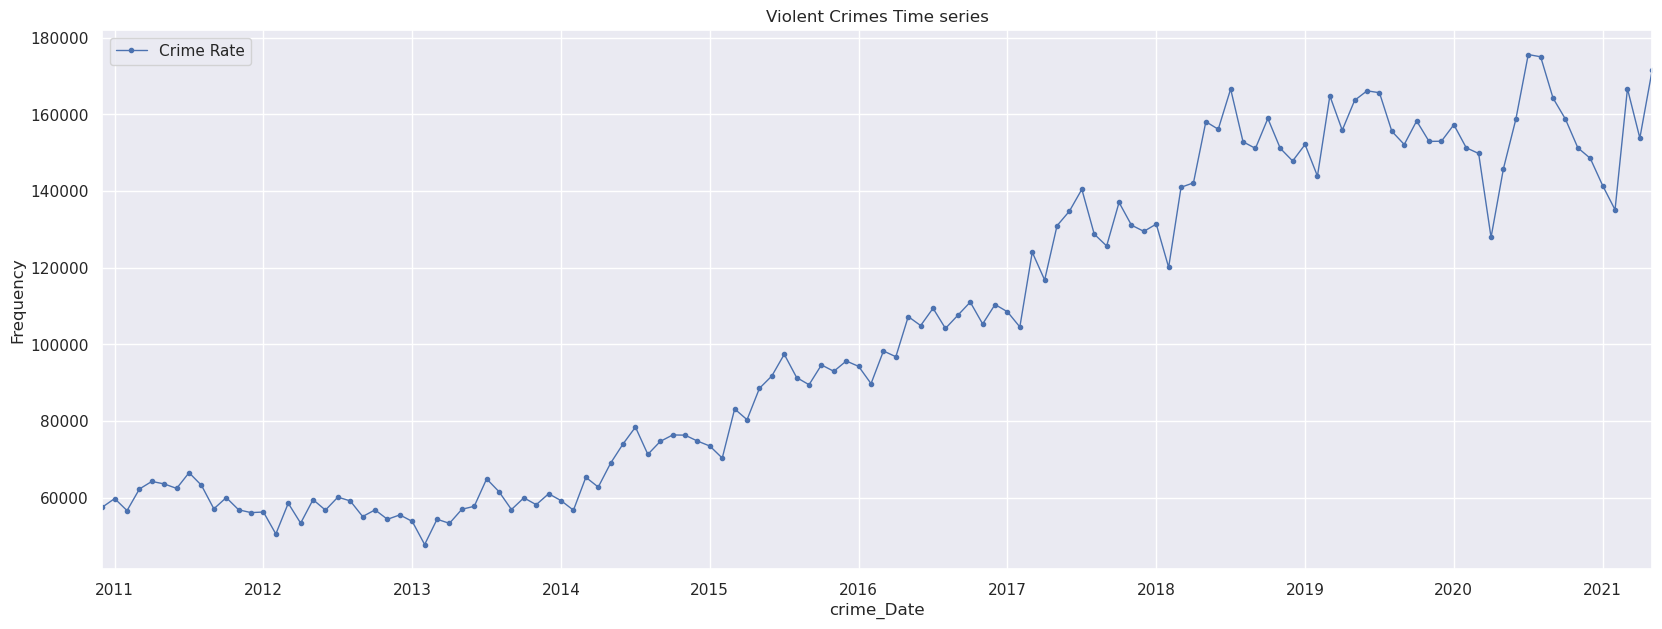

In [104]:
Violent_PD2.plot(y = 'CrimeFrequency', x = 'crime_Date', marker = '.', linewidth = 1.0,\
           subplots = False,
           label = 'Crime Rate',
           title = 'Violent Crimes Time series', figsize = (20,7))
plt.ylabel('Frequency');

plt.show()

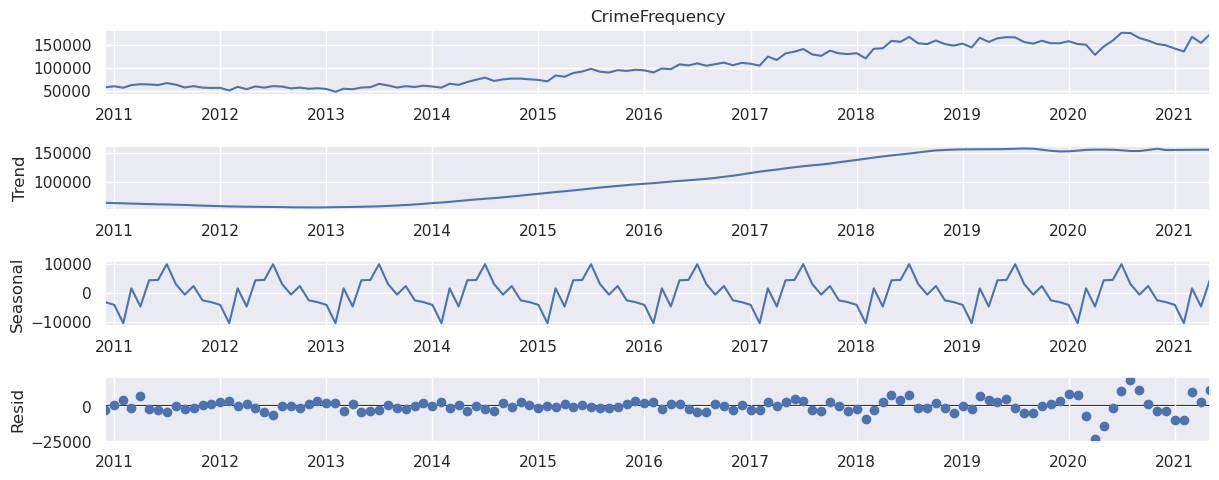

In [105]:
#Further decomposing the time series to get a more detailed trend in between years
decomposition = sm.tsa.seasonal_decompose(Violent_PD2['CrimeFrequency'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,5)
plt.show()

### Visual representaion of violent crime trend using a stack plot

The aim of this visualization is to explain explicitly the outcome of an analysis even to a layman who will not be able to interpret other forms of visualization clearly. The sharp edges denotes the peak of violent crime count for each month and year.

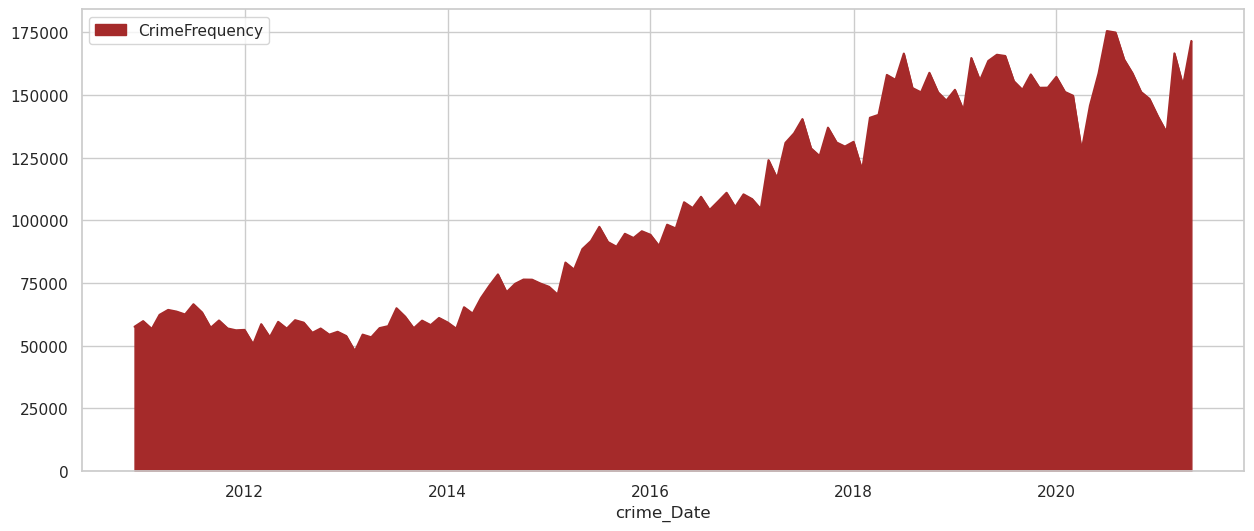

In [42]:
Violent_plot = Violent_PD.plot.area(y='CrimeFrequency',x='crime_Date', figsize =(15,6), color ='brown')
plt.show()

### Below is the Bar plot for Violent Crimes

Vertical or horizontal bars are used in bar graphs to visually display data along an x-axis and a y-axis. Each year is represented by a bar. An observer may quickly compare the various bars, or violent crime frequencies, when they are stacked next to one another. This visualization method aims to display the intensity of violent crimes with the height of each bar with respect to years. Most audiences are able to read bar graphs and understand the information they contain because they have been used widely in everything from textbooks to newspapers. 

A thread-like feature at the top of each bar denotes the extent of a crime rate before its slight retracement. This could be seen in every other year except 2010. This means that violent crimes were rising steadily in 2010 without any retracement in the last quarter. 

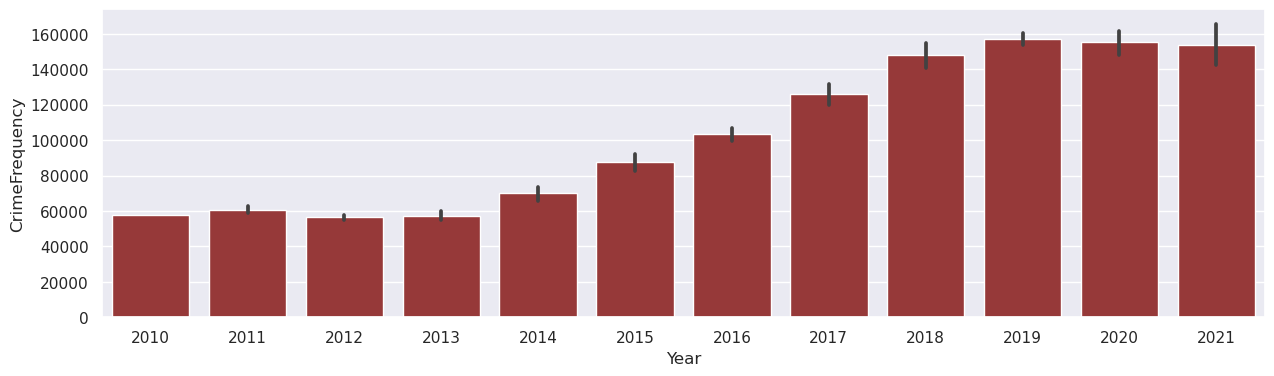

In [107]:
#subtracting the months from the year to reduce the bars from histogram 
Violent_PD['Year'] = pd.DatetimeIndex(Violent_PD['crime_Date']).year 
plt.figure(figsize = (15,4))
sns.barplot(x = 'Year', y = 'CrimeFrequency',data = Violent_PD, color = 'brown')

plt.show()

### scatter plot for violent crime over the years

The scatter plot will detect if there is either a positive, negative, or weak correlation between violent crime as the year progresses. Violent crimes are increasing, as seen by the direction of the scatter plot pointing to the right in a linear order. This also means that there is nearly a perfect correlation between violent crime frequency and the years as it progresses. 

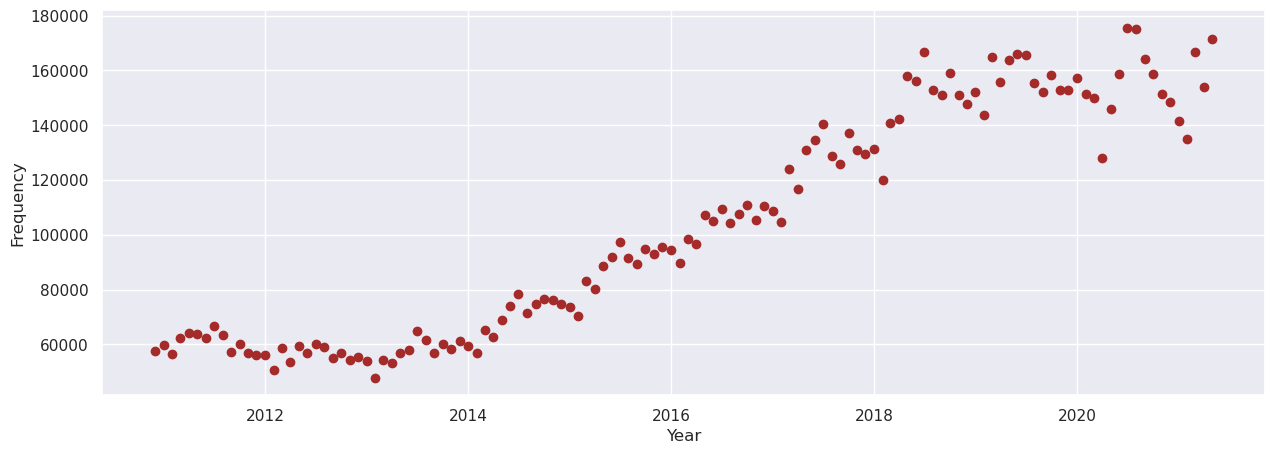

In [108]:
plt.figure(figsize=(15,5))
Violent_scatter = plt.scatter(x=Violent_PD['crime_Date'], y=Violent_PD['CrimeFrequency'], color = 'brown')
plt.xlabel("Year")
plt.ylabel("Frequency");
plt.show()

### Achieving stationarity 

A trend is typically defined as a change in the mean over time; detrending is the process of removing a trend from a time series. The essence is to take out a component that is believed to produce a distortion. To see sub trends, for instance, detrend data that shows an overall rise. These sub trends are typically depicted on a time series graph as fluctuations. It is more ideal to concentrate on methods for removing the overall trend for many reasons, which include pre-processing time series to identify and impute outliers and missing data, exploratory data analysis, extracting features from time series for later use in classification, regression, and forecasting tasks. In a bid to make the trend stationary, detrending and differencing were carried out in this phase.

In [109]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

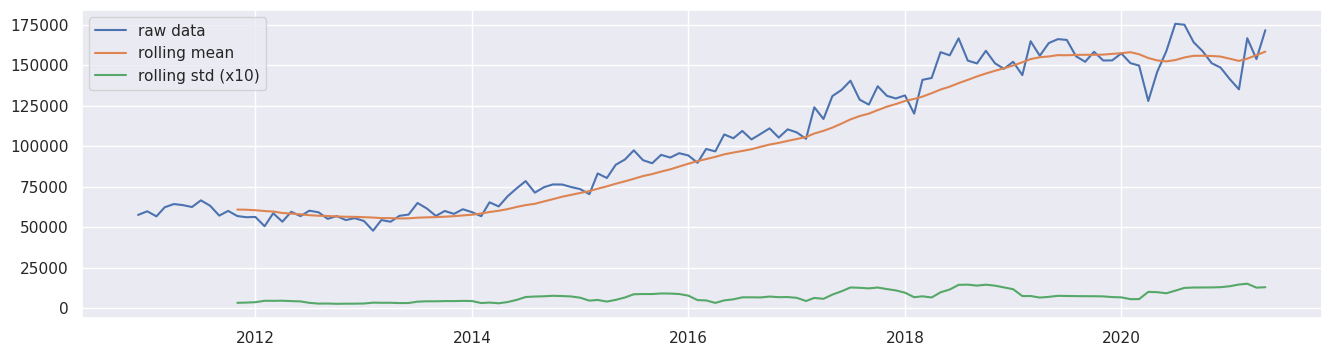

In [110]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(Violent_PD2['CrimeFrequency'],'raw data')

In [111]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [112]:
ADF_test(Violent_PD2['CrimeFrequency'],'raw data')

 > Is the raw data stationary ?
Test statistic = -0.305
P-value = 0.925
Critical values :
	1%: -3.489589552580676 - The data is not stationary with 99% confidence
	5%: -2.887477210140433 - The data is not stationary with 95% confidence
	10%: -2.580604145195395 - The data is not stationary with 90% confidence


<Figure size 640x480 with 0 Axes>

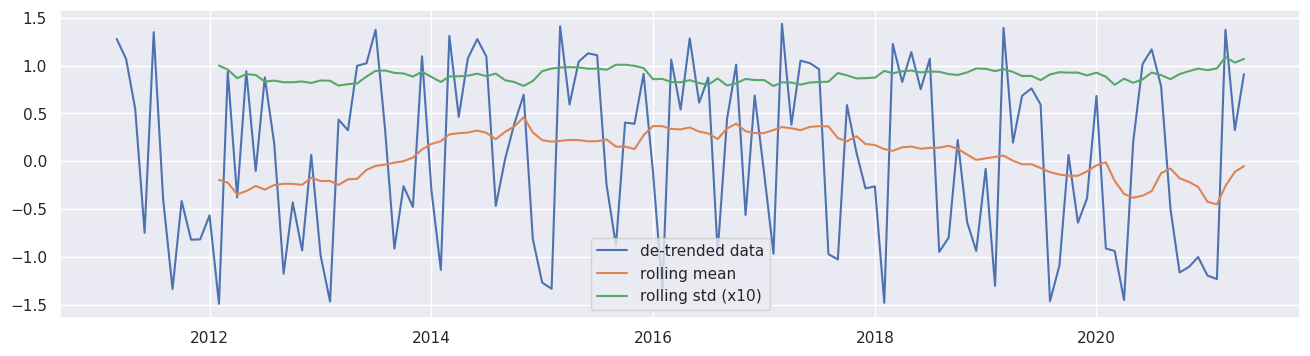

 > Is the de-trended data stationary ?
Test statistic = -1.742
P-value = 0.410
Critical values :
	1%: -3.49181775886872 - The data is not stationary with 99% confidence
	5%: -2.8884437992971588 - The data is not stationary with 95% confidence
	10%: -2.5811201893779985 - The data is not stationary with 90% confidence


In [113]:
# Detrending
y = Violent_PD2['CrimeFrequency']
y_detrend =  (y - y.rolling(window=4).mean())/y.rolling(window=4).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

<Figure size 640x480 with 0 Axes>

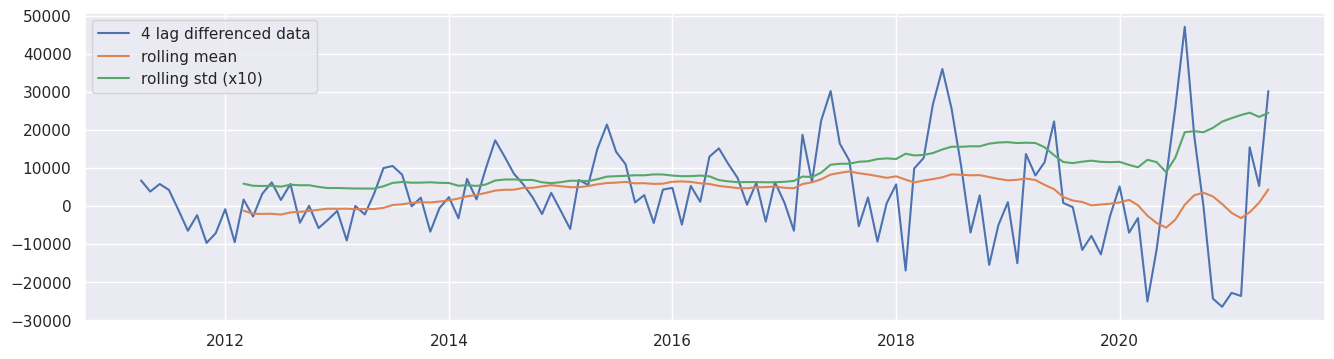

 > Is the 4 lag differenced data stationary ?
Test statistic = -1.545
P-value = 0.511
Critical values :
	1%: -3.4924012594942333 - The data is not stationary with 99% confidence
	5%: -2.8886968193364835 - The data is not stationary with 95% confidence
	10%: -2.5812552709190673 - The data is not stationary with 90% confidence


In [114]:
# Differencing
y_4lag =  y - y.shift(4)

test_stationarity(y_4lag,'4 lag differenced data')
ADF_test(y_4lag,'4 lag differenced data')

<Figure size 640x480 with 0 Axes>

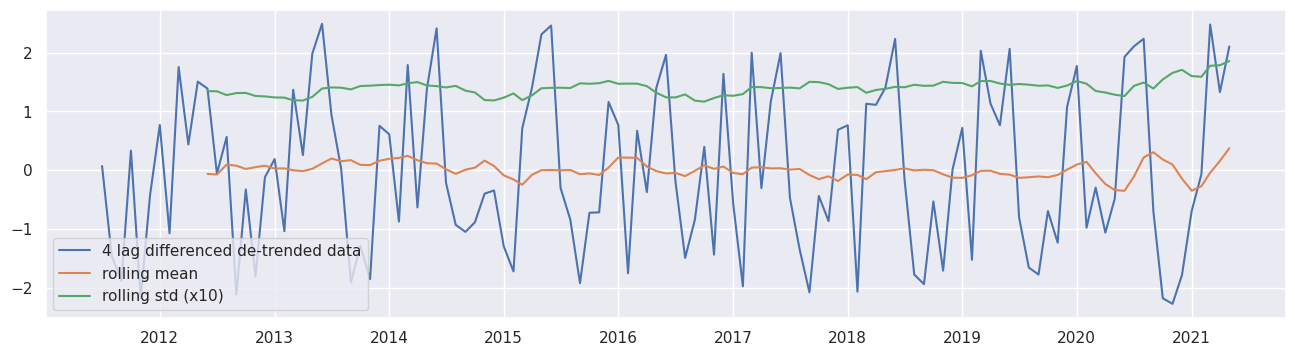

 > Is the 4 lag differenced de-trended data stationary ?
Test statistic = -6.527
P-value = 0.000
Critical values :
	1%: -3.4924012594942333 - The data is  stationary with 99% confidence
	5%: -2.8886968193364835 - The data is  stationary with 95% confidence
	10%: -2.5812552709190673 - The data is  stationary with 90% confidence


In [115]:
# Detrending + Differencing

y_4lag_detrend =  y_detrend - y_detrend.shift(4)

test_stationarity(y_4lag_detrend,'4 lag differenced de-trended data')

ADF_test(y_4lag_detrend,'4 lag differenced de-trended data')

### Correlation matrix and scatterplot(Drugs and fire arm incidents)

The statistical investigation of the link or dependence between two variables is called correlation. We can examine the direction and degree of the association between two sets of values using correlation. There are numerous practical uses for correlations. They can assist us in finding answers to problems like whether there is a connection between democracy and economic development or whether the number of automobiles on the road is related to the amount of air pollution. There three major types of correlation which are; 

  

A. Positive Correlation: When the values of two variables change in the same direction, this is referred to as positive correlation. For instance,  

  

B. Neutral Correlation: There is no connection between the change in variables X and Y. The values here are entirely random and do not exhibit any association at all 

  

C. Negative Correlation Last but not least, variables X and Y will have a negative correlation when their values vary in opposite directions. Therefore, in this case, as X increases, Y declines at a constant rate.

  

The correlation coefficient can be used as a general indicator of the strength of the association between variables because its value always falls between 1 and -1. A positive number indicates that the variables change together in the same direction, whereas a negative value indicates that they change together in the opposite direction. The sign of the coefficient indicates whether the variables change in the same or opposing directions. A number's absolute value is the same as the number without a sign. The degree of a correlation is indicated by the absolute value of the correlation coefficient; the stronger the correlation, the higher the absolute value. The correlation matrix was used for claim three to show the degree of relationship between firearm offenses and drugs. 

In [116]:
#converting Over_view data frame to pandas 
crimes_scatter = drugs_Fire.toPandas()

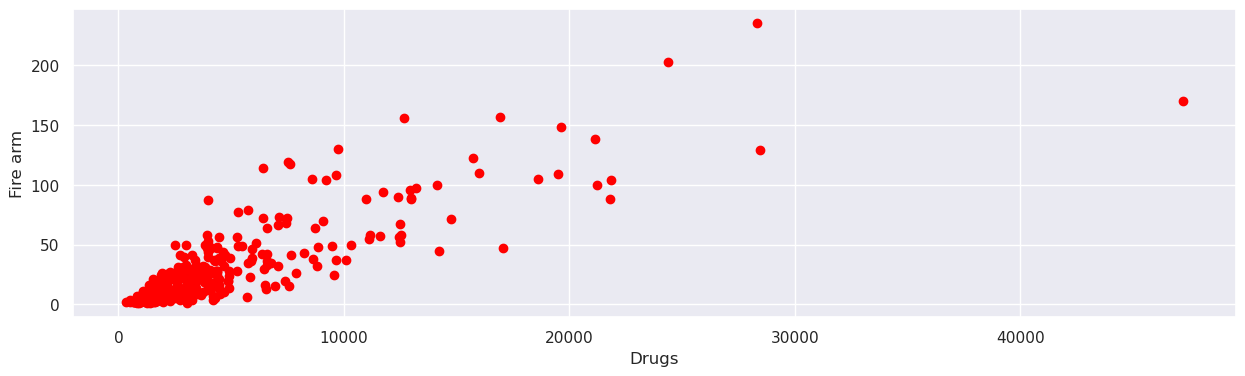

In [117]:
plt.figure(figsize=(15,4))
scatterDF = plt.scatter(x=crimes_scatter['Drug_Freq'], y=crimes_scatter['Fire_arm_Freq'], color = 'red')
plt.xlabel("Drugs")
plt.ylabel("Fire arm");
plt.show()

The above scatter plot shows a positive correlation of drugs and firearm incidents. Direction is taking shape towards the right with only one outlier to account for.

In [118]:
corrDF = drugs_Fire.drop('City')

corrDF.show(5)

+-------------+---------+
|Fire_arm_Freq|Drug_Freq|
+-------------+---------+
|           19|     1628|
|           48|     4369|
|           28|     2834|
|           43|     8241|
|           23|     3276|
+-------------+---------+
only showing top 5 rows



In [119]:
corrDF2 = corrDF.toPandas().corr()

In [120]:
vector_mat = "corr_features"
assembler = VectorAssembler(inputCols=corrDF.columns, outputCol=vector_mat)
vec_matrix = assembler.transform(corrDF).select(vector_mat)
vec_matrix.show(5)

+-------------+
|corr_features|
+-------------+
|[19.0,1628.0]|
|[48.0,4369.0]|
|[28.0,2834.0]|
|[43.0,8241.0]|
|[23.0,3276.0]|
+-------------+
only showing top 5 rows



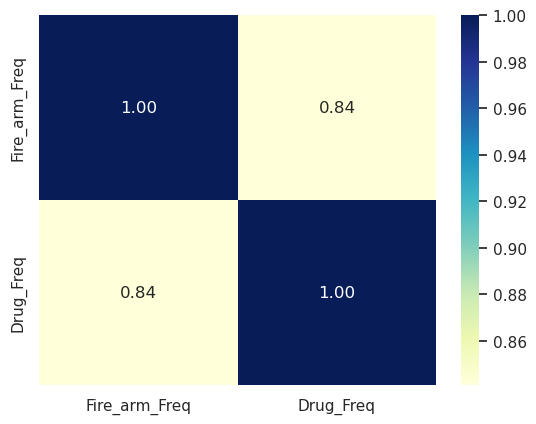

In [121]:
ax = sns.heatmap(corrDF2, annot=True, fmt=".2f", cmap="YlGnBu")

plt.show()

From the above output, the correlation coefficient is 1.0 and 0.81 respectively. This shows a positive correlation between fire arm incidents and drug offences

## Prediction model for violent crime

##### ARIMA: 


There were 1.5 million violent offenses in the calendar year ending March 2022, according to estimates from the Telephone-operated Crime Survey for England and Wales (TCSEW). 

There was no statistically significant change in the overall number of violent episodes using a comparable dataset that was corrected for variations in the sample and questionnaire between the CSEW and TCSEW. However, compared to the year ending March 2020, there was a statistically significant drop in the number of casualties (29% decrease) 

  

The autoregressive integrated moving average (ARIMA) was used for prediction. This model was adopted because it is best used to understand previous data while predicting future outcomes. This method assesses the significance of historical variations, takes broad trends into account, and deals with reducing the impact of outliers or brief aberrant changes in the data. ARIMA incorporates these ideas in its combined autoregressive and moving-average approach to modeling stationary time-series data. The historical trends, seasonality, unpredictability, and other non-static phenomena that people miss are all perfectly captured by ARIMA. 

  

The ARIMA model is defined by the formula ARIMA(p,d,q), where p, d, and q stand for the number of lag (or past) data to be considered for autoregression, the quantity of times the raw observations must be differentiated, and the dimension of the moving average window, respectively. 

  

Recall that the data used for this model has been made stationary in the previous section and has been labeled as 'y_4lag_detrend'. 

In [122]:
#converting the detrend data to csv
y_4lag_detrend.to_csv("y_4lag_detrend.csv")

In [123]:
#converting directly to pandas and declaring its date type
file = "y_4lag_detrend.csv"
predictdf = pd.read_csv(file, parse_dates=['crime_Date'])

In [124]:
#Changing data datetype and removing all Nulls
predictdf.crime_Date = predictdf.crime_Date.astype('datetime64[ns]')
y = predictdf.set_index(pd.to_datetime(predictdf.crime_Date)).dropna().CrimeFrequency
y.head()

crime_Date
2011-07-01    0.07081351
2011-08-01   -1.46467691
2011-09-01   -1.88424689
2011-10-01    0.33194756
2011-11-01   -2.16997164
Name: CrimeFrequency, dtype: float64

In [125]:
#choosing the train and test data intervals
train_data= y[:'2020-01-01']
Test_data = y['2021-01-01': ]
y_to_val = Test_data

In [126]:
#specify to ignore warning messages
warnings.filterwarnings("ignore") 

p = d = q = range(0, 2)
seasonal_period = 4
pdq = list(itertools.product(p, d, q))
seasonal_df = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_df[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_df[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_df[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_df[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 1, 0, 4)
SARIMAX: (0, 1, 0) x (0, 1, 1, 4)
SARIMAX: (0, 1, 0) x (1, 0, 0, 4)


In [127]:
for param in pdq:
    for param_seasonal in seasonal_df:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(train_data,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4)12 - AIC:353.1342105128605
ARIMA(0, 0, 0)x(0, 0, 1, 4)12 - AIC:273.8505190123484
ARIMA(0, 0, 0)x(0, 1, 0, 4)12 - AIC:448.9214848269566
ARIMA(0, 0, 0)x(0, 1, 1, 4)12 - AIC:358.2761381810799
ARIMA(0, 0, 0)x(1, 0, 0, 4)12 - AIC:326.47950765948036
ARIMA(0, 0, 0)x(1, 0, 1, 4)12 - AIC:268.2806889263386
ARIMA(0, 0, 0)x(1, 1, 0, 4)12 - AIC:417.9016023280367
ARIMA(0, 0, 0)x(1, 1, 1, 4)12 - AIC:335.6714729732259
ARIMA(0, 0, 1)x(0, 0, 0, 4)12 - AIC:350.30744569017884
ARIMA(0, 0, 1)x(0, 0, 1, 4)12 - AIC:270.1441636840828
ARIMA(0, 0, 1)x(0, 1, 0, 4)12 - AIC:446.412111631479
ARIMA(0, 0, 1)x(0, 1, 1, 4)12 - AIC:355.62280658067465
ARIMA(0, 0, 1)x(1, 0, 0, 4)12 - AIC:323.51328276164844
ARIMA(0, 0, 1)x(1, 0, 1, 4)12 - AIC:263.83646248272044
ARIMA(0, 0, 1)x(1, 1, 0, 4)12 - AIC:415.076104043029
ARIMA(0, 0, 1)x(1, 1, 1, 4)12 - AIC:332.9063359266876
ARIMA(0, 1, 0)x(0, 0, 0, 4)12 - AIC:394.3217215563006
ARIMA(0, 1, 0)x(0, 0, 1, 4)12 - AIC:313.68275594334665
ARIMA(0, 1, 0)x(0, 1, 0,

In [128]:
#Using Values from the initial step
order = (0, 0, 0) 
seasonal_order = (0, 0, 1, 4)
model = sm.tsa.statespace.SARIMAX(train_data,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

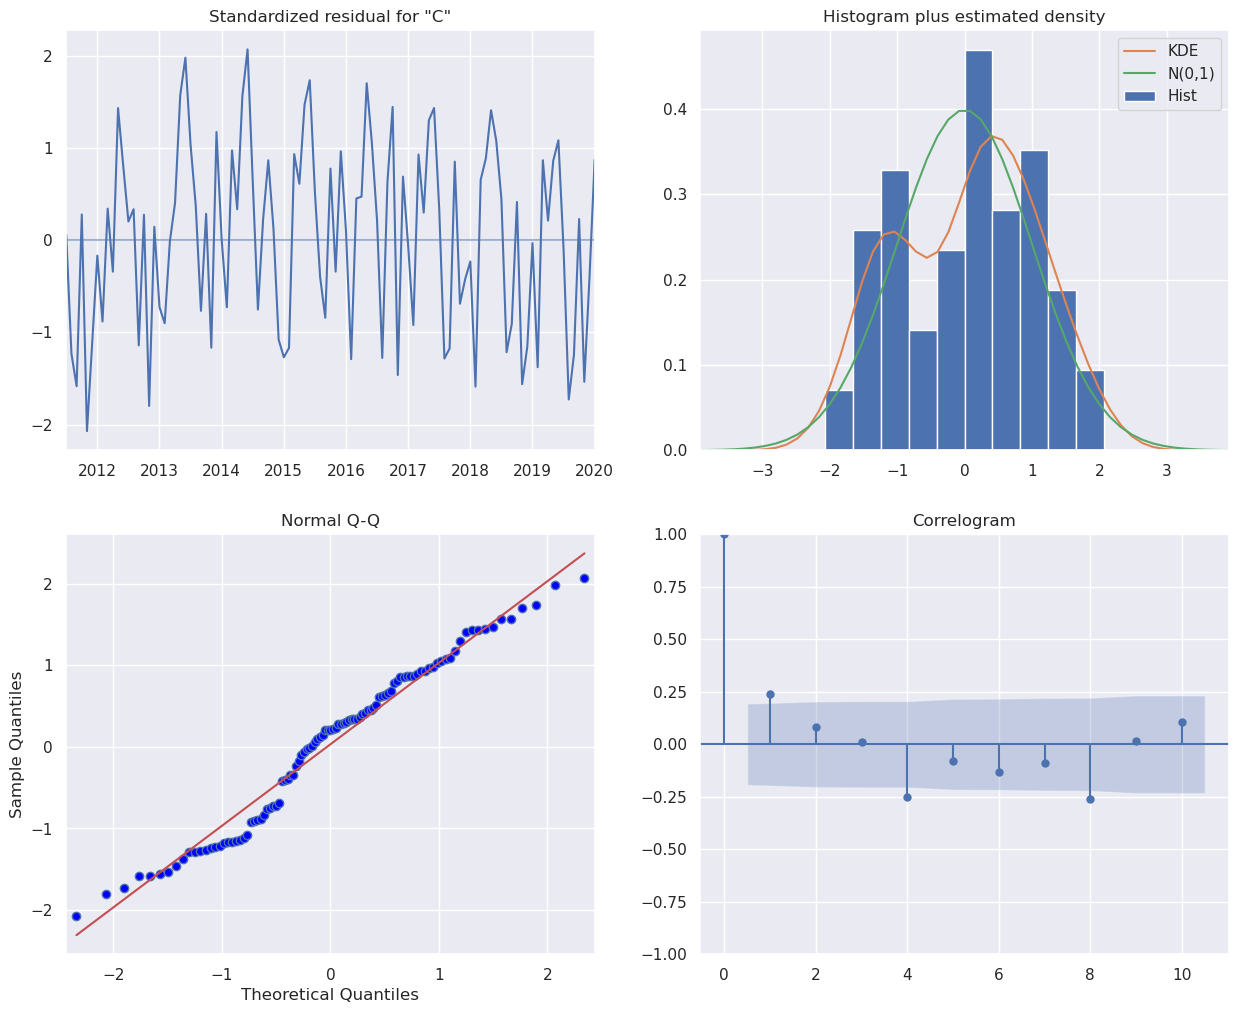

In [129]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [130]:
pred_uc = results.get_forecast(steps=4)

pred_ci = pred_uc.conf_int()

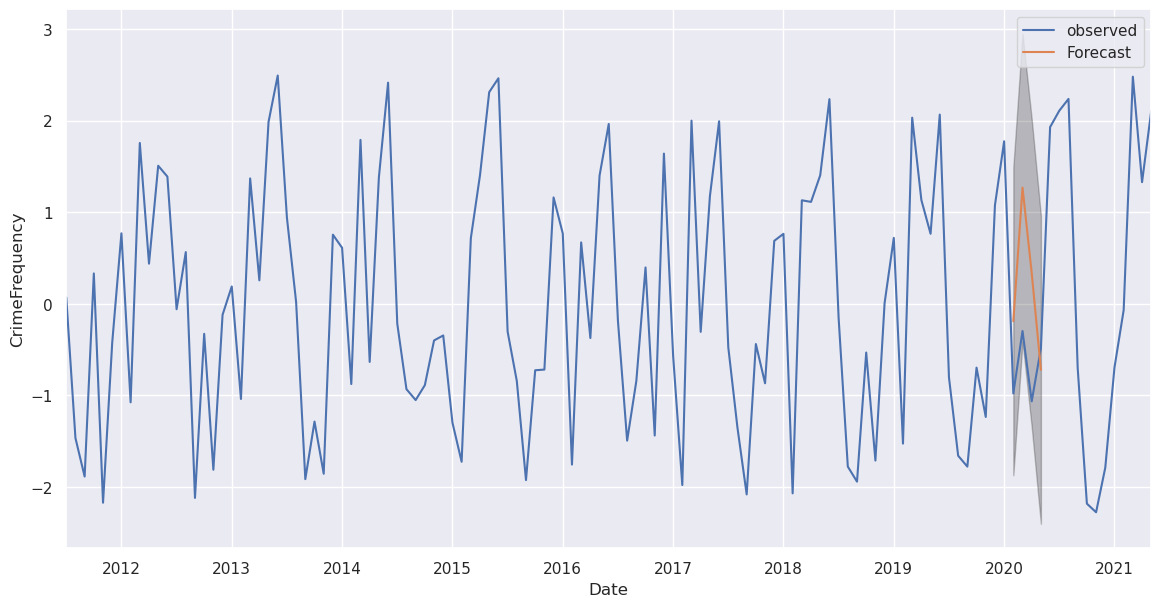

In [131]:
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')#print(pred_uc.predicted_mean)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

From the above plot, the observed trend remained stationary as it should while the forcast line tends to be a downward movement. This shows that the rate of violent crime in the Uk will decrease over time.

In [132]:
# Produce the forcasted tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_dataframe = pm.join(pci.set_index('Date'), on='Date')

In [133]:
final_dataframe.head(12)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2020-02-01,-0.18961315,-1.86994570,1.49071940
1,2020-03-01,1.26827745,-0.41090221,2.94745712
2,2020-04-01,0.33649151,-1.34268815,2.01567118
3,2020-05-01,-0.72039586,-2.39957552,0.95878381


In [134]:
Test_data.head(12)

crime_Date
2021-01-01   -0.69522368
2021-02-01   -0.06847649
2021-03-01    2.47893861
2021-04-01    1.32807330
2021-05-01    2.10610234
Name: CrimeFrequency, dtype: float64

## Testing for stationarity (Explained)

In order to ensure that there is no apparent correlation or collinearity within the historical data, it is necessary to transform time series data into a stationary form. Stationary time series data means that the values or features of a given observation are independent of the specific time at which it was recorded. 

For example, let's consider a hypothetical dataset representing the population of an area over the years. If the data shows that the population doubles every year or increases by a fixed amount, it would be considered non-stationary. This is because each observation is heavily influenced by the specific year it represents, making the population value dependent on its temporal relationship to a chosen reference year. 

When training a model using time series data, such dependence on the time component can introduce biases and inaccuracies. By transforming the data into a stationary form, we aim to remove this temporal dependency, allowing for more reliable and unbiased modeling.

In [136]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

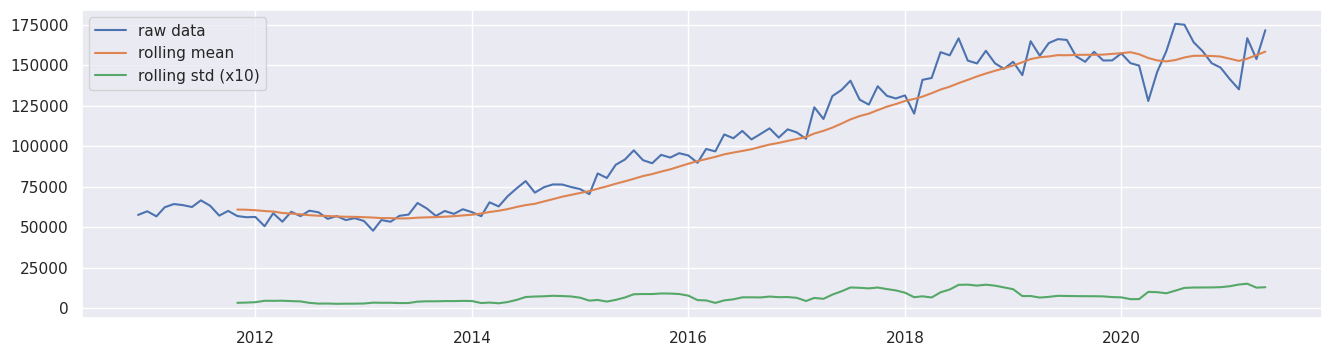

In [137]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(Violent_PD2['CrimeFrequency'],'raw data')

The p-value obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.


In [ ]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [ ]:
ADF_test(Violent_PD2['CrimeFrequency'],'raw data')

<Figure size 640x480 with 0 Axes>

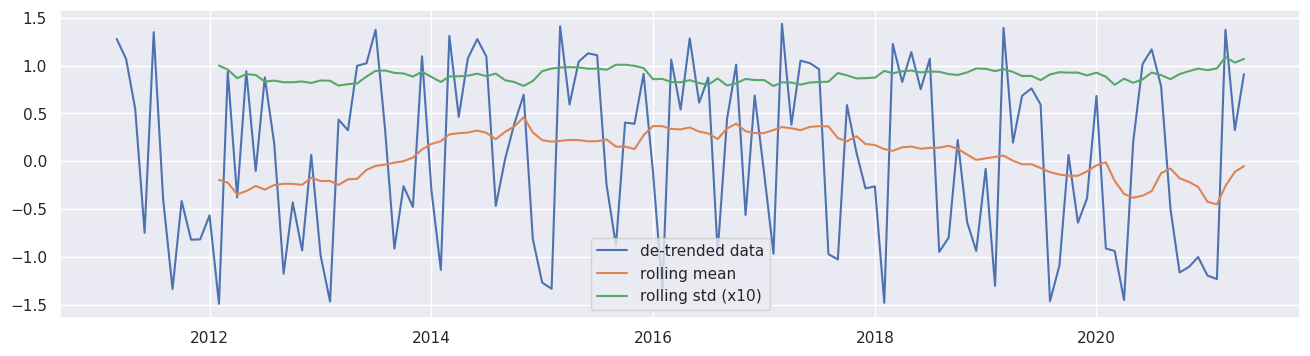

 > Is the de-trended data stationary ?
Test statistic = -1.742
P-value = 0.410
Critical values :
	1%: -3.49181775886872 - The data is not stationary with 99% confidence
	5%: -2.8884437992971588 - The data is not stationary with 95% confidence
	10%: -2.5811201893779985 - The data is not stationary with 90% confidence


In [138]:
# Detrending
y = Violent_PD2['CrimeFrequency']
y_detrend =  (y - y.rolling(window=4).mean())/y.rolling(window=4).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

The above detrending was done yet the data was not stationary with a rolling window of of 4. Next step will be to apply differencing on the data in the bid of achieving stationarity.

<Figure size 640x480 with 0 Axes>

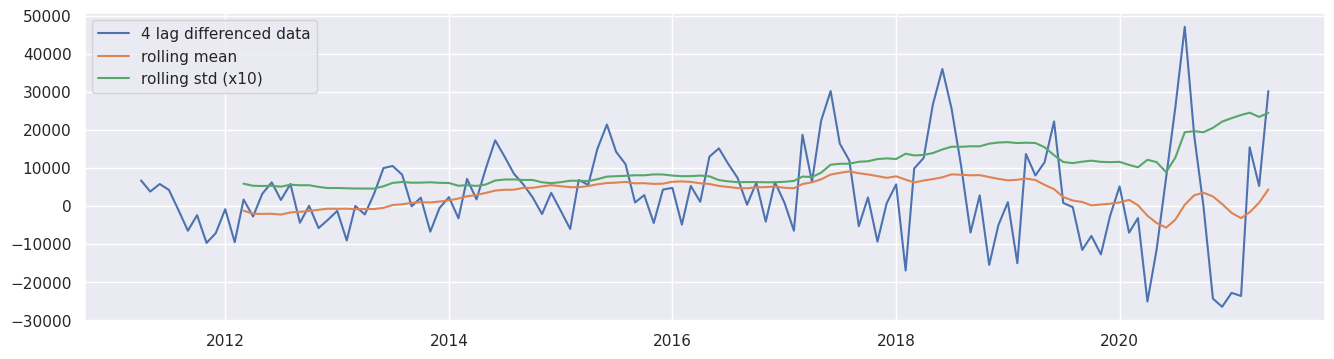

 > Is the 4 lag differenced data stationary ?
Test statistic = -1.545
P-value = 0.511
Critical values :
	1%: -3.4924012594942333 - The data is not stationary with 99% confidence
	5%: -2.8886968193364835 - The data is not stationary with 95% confidence
	10%: -2.5812552709190673 - The data is not stationary with 90% confidence


In [139]:
# Differencing
y_4lag =  y - y.shift(4)

test_stationarity(y_4lag,'4 lag differenced data')
ADF_test(y_4lag,'4 lag differenced data')

The ADF statistic is still higher than any of the crucial values, and the p value produced is still more than the significance level of 0.05. There is obviously no justification to reject the null hypothesis. As a result, the time series is not yet stationary. 

<Figure size 640x480 with 0 Axes>

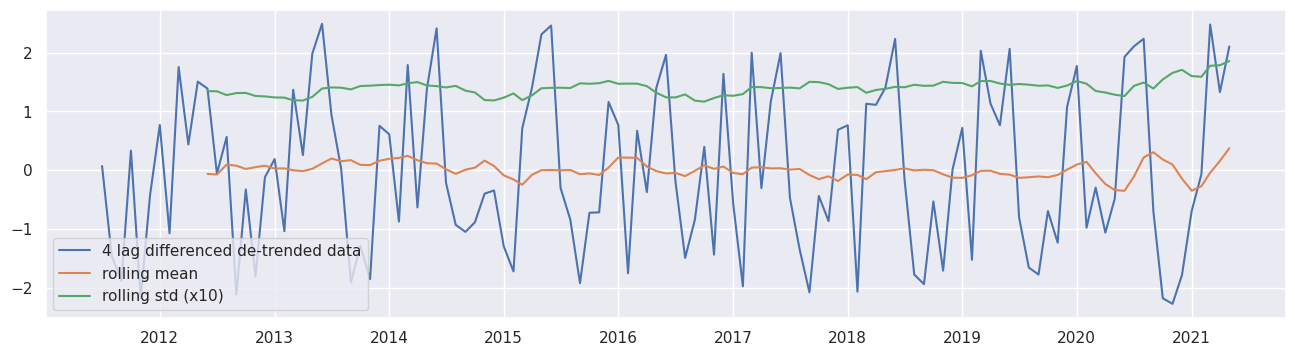

 > Is the 4 lag differenced de-trended data stationary ?
Test statistic = -6.527
P-value = 0.000
Critical values :
	1%: -3.4924012594942333 - The data is  stationary with 99% confidence
	5%: -2.8886968193364835 - The data is  stationary with 95% confidence
	10%: -2.5812552709190673 - The data is  stationary with 90% confidence


In [140]:
# Detrending + Differencing

y_4lag_detrend =  y_detrend - y_detrend.shift(4)

test_stationarity(y_4lag_detrend,'4 lag differenced de-trended data')

ADF_test(y_4lag_detrend,'4 lag differenced de-trended data')

With The p-value as 0.00, is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary. The above visualised series clearly confirms this.

### Correlation matrix for Drugs and fire arm incidents (EXPLAINED)

The p-value and coefficient r between -1 and +1 of a Pearson correlation coefficient indicate if there is a linear relationship between two variables and how strong it is. Only when its underlying assumptions are met may it be applied. If the result is noteworthy, we draw the conclusion that a correlation exists. By Cohen's definition (1988), an absolute value of r of 0.1 is considered tiny, 0.3 is considered medium, and 0.5 is considered big


In [142]:
vector_mat = "corr_features"
assembler = VectorAssembler(inputCols=corrDF.columns, outputCol=vector_mat)
vec_matrix = assembler.transform(corrDF).select(vector_mat)
vec_matrix.show(5)

+-------------+
|corr_features|
+-------------+
|[19.0,1628.0]|
|[48.0,4369.0]|
|[28.0,2834.0]|
|[43.0,8241.0]|
|[23.0,3276.0]|
+-------------+
only showing top 5 rows



The above table shows the correlation coefficients for various variables(Fire arm and drug offences). The correlation between all potential pairs of values in a table is shown in the matrix. It is an effective tool for compiling a sizable dataset and for locating and displaying data patterns.

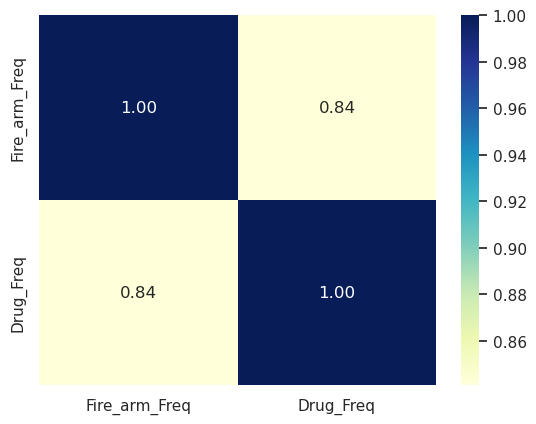

In [143]:
ax = sns.heatmap(corrDF2, annot=True, fmt=".2f", cmap="YlGnBu")

plt.show()